In [15]:
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import statistics
import pandas as pd
%matplotlib inline

In [16]:
## basic read in

In [17]:
def largest_several_mean(acc_list,count,neglect=5):
    acc_list.sort()
    sub_list = acc_list[-count-neglect:-neglect]
    my_mean = sum(sub_list) / len(sub_list)
    return my_mean

In [18]:
def max_acc_point(acc_list):
    acc_point = np.argmax(acc_list)
    return acc_point

In [19]:
def min_loss_point(loss_list):
    loss_point = np.argmin(loss_list)
    return loss_point

In [20]:
def es_point(acc_list,p): # p means steps after the max index
    max_num = 0
    count = 0
    for i in range(len(acc_list)):
        if acc_list[i]>max_num:
            max_num = acc_list[i]
            count = 0
        count = count+1
        if count>p:
            return i-1
    return int(len(acc_list)-1)
    
    
#     max_index=np.where(acc_list==np.amax(acc_list))
#     max_index=max_index[0]+p
#     return max_index[0]

In [21]:
def compute_last_mean(acc_list,window=100):
    sub_list = acc_list[-window:]
    last_mean = sum(sub_list) / len(sub_list)
    return last_mean

In [22]:
def windowed(s,half_window): # s in a list
    s_mean=[]
    s_var=[]
    window_size = half_window*2
    for i in range(len(s)-window_size+1):
        k = i + half_window
        s_sub=s[k-half_window:k+half_window]
        sub_mean=sum(s_sub)/len(s_sub)
        s_mean.append(sub_mean)
        sub_var=statistics.variance(s_sub)
        s_var.append(sub_var)
    return s_mean,s_var

In [23]:
def read_acc_mean(files,i,speed=1):
    fileset = pd.concat( [pd.read_csv(f,header=None,sep=' ',names=['loss','acc'])['acc'] for f in files], axis=1)
    normalset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==False], axis=1)
    normalset_mean = normalset.mean(axis=1).dropna()
    if speed==1:
        return normalset_mean   
    delayset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==True], axis=1)
    delayset_mean = delayset.mean(axis=1).dropna()
    return normalset_mean,delayset_mean
def read_loss_mean(files,i,speed=1):
    fileset = pd.concat( [pd.read_csv(f,header=None,sep=' ',names=['loss','acc'])['loss'] for f in files], axis=1)
    normalset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==False], axis=1)
    normalset_mean = normalset.mean(axis=1).dropna()
    if speed==1:
        return normalset_mean   
    delayset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==True], axis=1)
    delayset_mean = delayset.mean(axis=1).dropna()
    return normalset_mean,delayset_mean

In [24]:
## how to plot

In [25]:
def plot_line(i,k,basedir,result,lab,es=500,min_loss_stopping=False,addon=''):
    s1=np.load(os.path.join(basedir,result[k]))
    p=es_point(s1[2],es)
    if min_loss_stopping:
        p = min_loss_point(s1[1])
    s1_epo = [i+1 for i in s1[0][:p]]
    ax[i].plot(s1_epo,s1[2][:p], label=lab[k]+addon)

In [49]:
def plot_window_acc(i,k,half_window,basedir,result,lab,es=500,min_loss_stopping=False,addon=''):
    s1=np.load(os.path.join(basedir,result[k]))
    p=es_point(s1[2],es)
    if min_loss_stopping:
        p = min_loss_point(s1[1])
    (s_mean,s_varience)=windowed(s1[2][:p],half_window)
    s_epo=[i+1 for i in range(len(s_mean))]
    ax[i].plot(s_epo,s_mean, label=lab[k]+addon) # can also plot s_varience if want
    (s_loss,_)=windowed(s1[1][:p],half_window_size)
    
#     index_min_loss = min_loss_point(s_loss)
#     ax[i].plot(index_min_loss,s_mean[index_min_loss],'ks')

    index_max=np.argmax(s_mean)
    ax[i].plot(index_max,s_mean[index_max],'ks')


In [27]:
def plot_file_acc(i,k,basedir,node_dir,lab,speed=1,filename='self_EVAL.txt'):
    files = glob.glob(basedir +'/'+ node_dir[k]+ '/worker_nodes/*/'+filename)
    linelab = lab[k]
    if speed==1:
        normalset_mean = read_acc_mean(files,i,speed)
        set_plt = [i+1 for i in range(len(normalset_mean))]
        ax[i].plot(set_plt,normalset_mean, label=linelab+'_usual')
#         print('only usual')
        
    else:
        normalset_mean,delayset_mean = read_acc_mean(files,i,speed)
        
        normal_plt = [i+1 for i in range(len(normalset_mean))]
        ax[i].plot(normal_plt,normalset_mean, label=linelab+'_usual')
        
        new_delay_set = [val for val in delayset_mean for _ in range(speed)]
        delay_plt = [i+1 for i in range(len(new_delay_set))]
        ax[i].plot(delay_plt,new_delay_set, label=linelab+'_delay')

In [28]:
def plot_file_window_acc(i,k,half_window,basedir,node_dir,lab,speed=1,filename='self_EVAL.txt'):
    files = glob.glob(basedir +'/'+ node_dir[k]+ '/worker_nodes/*/'+filename)
    linelab = lab[k]
    if speed==1:
        normalset_mean = read_acc_mean(files,i,speed)
        (s_mean,s_varience)=windowed(normalset_mean,half_window)
        s_epo=[i+half_window+1 for i in range(len(s_mean))]
        ax[i].plot(s_epo,s_mean, label=linelab)
    else:
        normalset_mean,delayset_mean = read_acc_mean(files,i,speed)

        (s_mean,s_varience)=windowed(normalset_mean,half_window)
        s_epo=[i+1 for i in range(len(s_mean))]
        ax[i].plot(s_epo,s_mean, label=linelab+'_usual')
        
        new_delay_set = [val for val in delayset_mean for _ in range(speed)]
        (s_mean,s_varience)=windowed(new_delay_set,half_window)
        s_epo=[i+half_window+1 for i in range(len(s_mean))]
        ax[i].plot(s_epo,s_mean, label=linelab+'_delay')


## Data Dispersion

In [40]:
basedir=os.path.join('DataDispersion')
# os.listdir(basedir)

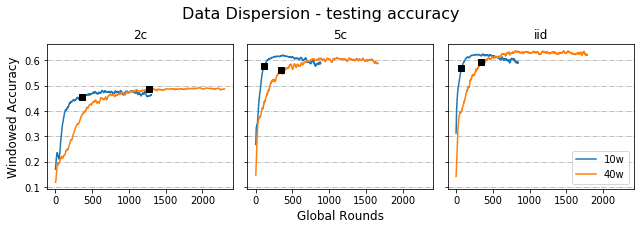

In [41]:
# fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(9, 3))
# fig.suptitle('Data Dispersion - testing accuracy',y=1.05,fontsize=16)
# # fig.suptitle('Data Dispersion - training accuracy',y=1.05,fontsize=16)


# result=[
#     '2c.10w.4000.loc1.earlystop500.20200501-072809.npy',
#     '2c.40w.4000.loc1.earlystop500.20200507-172304.npy',

#     '5c.10w.4000.loc1.earlystop500.20200501-024326.npy',
#     '5c.40w.4000.loc1.earlystop500.20200506-215910.npy',

#      'iid.10w.4000.loc1.earlystop500.20200501-020117.npy',
#     'iid.40w.4000.loc1.earlystop500.20200507-014322.npy'
    
#        ]

# lab=[
#  '2c.10w',
#  '2c.40w',
#  '5c.10w',
#  '5c.40w',
#  '10w',
#  '40w'
#        ]

# node_dir = [
#     'loc2c1s',
#     'dd2',
    
#     'loc5c1s',
#     'dd5',
    
#     'lociid1s',
#     'ddiid'
# ]

# x = 2
# title_list = ['2c','5c','iid']

# for i in range(3):
    
#     for j in range(x):
#         k= i*x+j
#         half_window=10
        
# #         plot_line(i,k,basedir,result,lab,es=500,min_loss_stopping=False,addon='')
# #         plot_file_acc(i,k,basedir,node_dir,lab,speed=1,filename='self_EVAL.txt')
#         plot_window_acc(i,k,half_window,basedir,result,lab,es=500,min_loss_stopping=False,addon='')
# #         plot_file_window_acc(i,k,half_window,basedir,node_dir,lab,speed=1,filename='self_EVAL.txt')
        

#     ax[1].set_xlabel('Global Rounds',fontsize=12)
# #     ax[i].set_ylim([0.35, 0.35+0.35])
# #     ax[i].set_ylim([0.7, 0.7+0.35])
#     ax[i].grid(axis="y",ls='-.')
#     ax[i].set_title(title_list[i])
# ax[0].set_ylabel('Windowed Accuracy',fontsize=12)
# ax[2].legend() 
# plt.tight_layout()
# plt.show()

## Bad Node

In [42]:
basedir=os.path.join('BadNode')
# os.listdir(basedir)

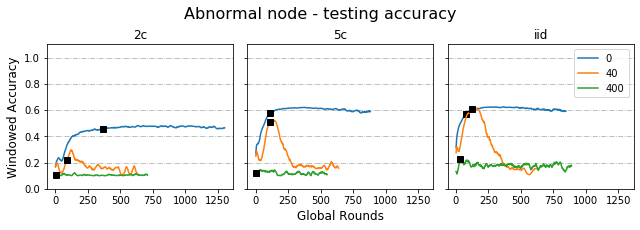

In [43]:
# fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(9, 3))
# fig.suptitle('Abnormal node - testing accuracy',y=1.05,fontsize=16)
# # fig.suptitle('Abnormal node - training accuracy',y=1.05,fontsize=16)

# result=[
    
    
#     '2c.10w.4000.loc1.earlystop500.20200501-072809.npy',
#  '2c.10w.4000.plus1bad_each40.loc1.earlystop500.20200501-015142.npy',
#  '2c.10w.4000.plus1bad_each400.loc1.earlystop500.20200501-031558.npy',
    
#     '5c.10w.4000.loc1.earlystop500.20200501-024326.npy',
#  '5c.10w.4000.plus1bad_each40.loc1.earlystop500.20200501-023155.npy',
#  '5c.10w.4000.plus1bad_each400.loc1.earlystop500.20200501-004052.npy',
    
#     'iid.10w.4000.loc1.earlystop500.20200501-020117.npy',
#  '11d.10w.4000.plus1bad_each40.loc1.earlystop500.20200501-020918.npy',
#  '11d.10w.4000.plus1bad_each400.loc1.earlystop500.20200501-060927.npy'
#        ]

# lab=['','','','','','','0','40','400']

# node_dir = ['loc2c1s','bad2c40','bad2c400','loc5c1s', 'bad5c40','bad5c400','lociid1s','badiid40','badiid400']

# title_list = ['2c','5c','iid']

# for i in range(3):    
#     for j in range(3):
#         k = i*3+j
#         half_window=10
        
# #         plot_line(i,k,basedir,result,lab,es=500,min_loss_stopping=False,addon='')
# #         plot_file_acc(i,k,basedir,node_dir,lab,speed=1,filename='self_EVAL.txt')
#         plot_window_acc(i,k,half_window,basedir,result,lab,es=500,min_loss_stopping=False,addon='')
# #         plot_file_window_acc(i,k,half_window,basedir,node_dir,lab,speed=1,filename='self_EVAL.txt')        
        

#     ax[1].set_xlabel('Global Rounds',fontsize=12)
#     ax[i].set_ylim([0, 1.1])
#     ax[i].grid(axis="y",ls='-.')
#     ax[i].set_title(title_list[i])
# ax[0].set_ylabel('Windowed Accuracy',fontsize=12)
# ax[2].legend() 
# plt.tight_layout()
# plt.show()

## Local Steps

In [44]:
basedir=os.path.join('LocalStep')
# os.listdir(basedir)

## Share Data

In [46]:
basedir=os.path.join('ShareData')
# os.listdir(basedir)

['1c.10w.4000.share100.loc1.earlystop500.20200504-211245.npy',
 '1c.10w.4000.share100_epoiid.loc1.earlystop500.20200505-052608.npy',
 '1c.10w.4000.share400.loc1.earlystop500.20200505-011914.npy',
 '1c.10w.4000.share400_epoiid.loc1.earlystop500.20200505-022211.npy',
 '1c.10w.4000.share800.loc1.earlystop500.20200505-014623.npy',
 '1c.10w.4000.share800_epoiid.loc1.earlystop500.20200505-004219.npy',
 'iid.10w.4000.share100.loc1.earlystop500.20200505-111139.npy',
 'iid.10w.4000.share400.loc1.earlystop500.20200505-113732.npy',
 'iid.10w.4000.share800.loc1.earlystop500.20200505-125048.npy',
 'iidsd1',
 'iidsd4',
 'iidsd8',
 'sde1',
 'sde4',
 'sde8',
 'sdn1',
 'sdn4',
 'sdn8',
 'zOLD']

## Late update in some node

In [57]:
basedir=os.path.join('DelayUpdate')
# os.listdir(basedir)

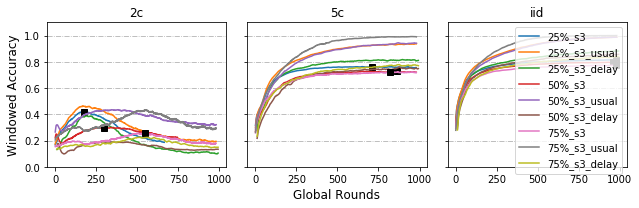

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(9, 3))
# fig.suptitle('Delayed Update - testing accuracy',y=1.05,fontsize=16)
# fig.suptitle('Delayed Update - training accuracy',y=1.05,fontsize=16)

title_list = ['2c','5c','iid']

# in order: dly8-30/12/3, dly20, dly32
result=[
    '2c.40w.40000.dly10.speed3.loc1.earlystop1000.20200522-081302.npy',
    '2c.40w.40000.dly20.speed3.loc1.earlystop1000.20200522-010225.npy',
    '2c.40w.40000.dly30.speed3.loc1.earlystop1000.20200521-182838.npy',    
    '2c.40w.40000.dly10.speed15.loc1.earlystop1000.20200522-051203.npy',    
    '2c.40w.40000.dly10.speed30.loc1.earlystop1000.20200522-050704.npy',
    

    '5c.40w.40000.dly10.speed3.loc1.earlystop1000.20200522-074328.npy',
    '5c.40w.40000.dly20.speed3.loc1.earlystop1000.20200522-010608.npy',
    '5c.40w.40000.dly30.speed3.loc1.earlystop1000.20200521-184510.npy',  
    '5c.40w.40000.dly10.speed15.loc1.earlystop1000.20200522-043519.npy',    
    '5c.40w.40000.dly10.speed30.loc1.earlystop1000.20200522-053311.npy',


    'iid.40w.40000.dly10.speed3.loc1.earlystop1000.20200522-072117.npy',
    'iid.40w.40000.dly20.speed3.loc1.earlystop1000.20200522-012812.npy',
    'iid.40w.40000.dly30.speed3.loc1.earlystop1000.20200521-185705.npy',   
    'iid.40w.40000.dly10.speed15.loc1.earlystop1000.20200522-053936.npy',    
    'iid.40w.40000.dly10.speed30.loc1.earlystop1000.20200522-073107.npy',  
]

lab=[
    '25%_s3','50%_s3','75%_s3', '25%_s15','25%_s30', 
    '25%_s3','50%_s3','75%_s3', '25%_s15','25%_s30',     
    '25%_s3','50%_s3','75%_s3', '25%_s15','25%_s30', 
]


node_dir = [
    'du2c1','du2c2','du2c3','du2c4','du2c5',
    'du5c1','du5c2','du5c3','du5c4','du5c5',
    'duiid1','duiid2','duiid3','duiid4','duiid5'
]

speed_list = [3,3,3,15,30,3,3,3,15,30,3,3,3,15,30]


for i in range(3):
    
    for j in [0,1,2]:
        
        k = i*5+j
        half_window_size=10
        speed = speed_list[k]
#         print(speed)
        
        half_window=10
        
#         plot_line(i,k,basedir,result,lab,es=500,min_loss_stopping=False,addon='')
#         plot_file_acc(i,k,basedir,node_dir,lab,speed,filename='self_EVAL.txt')
        plot_window_acc(i,k,half_window,basedir,result,lab,es=500,min_loss_stopping=False,addon='')
        plot_file_window_acc(i,k,half_window,basedir,node_dir,lab,speed,filename='self_EVAL.txt')
        

    ax[1].set_xlabel('Global Rounds',fontsize=12)
    ax[i].set_ylim([0, 1.1])
    ax[i].grid(axis="y",ls='-.')
    ax[i].set_title(title_list[i])
ax[0].set_ylabel('Windowed Accuracy',fontsize=12)
ax[2].legend() 
plt.tight_layout()
plt.show()